# French Bonds Analysis
This notebook scrapes French funds data from tradingeconomics.com , performs analysis, and creates visualizations.

In [21]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('deep')


# Web Scraping

In [22]:
def scrape_french_bonds():
    url = 'https://tradingeconomics.com/france/20-year-bond-yield'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Initialize lists to store data
        maturities = []
        yields = []
        
        # Find the table containing bond data
        table = soup.find('table')
        if table:
            rows = table.find_all('tr')[1:]  # Skip header row
            for row in rows:
                cols = row.find_all('td')
                if len(cols) >= 2:
                    maturities.append(cols[0].text.strip())
                    yields.append(float(cols[1].text.strip().replace('%', '')))
        
        # Create DataFrame
        df = pd.DataFrame({
            'Maturity': maturities,
            'Yield': yields
        })
        
        return df
    
    except Exception as e:
        print(f'Error scraping data: {e}')
        return None

# Fecth The Data

In [23]:
bonds_df = scrape_french_bonds()

if bonds_df is not None:
    print('French Government Bonds Data:')
    display(bonds_df)

French Government Bonds Data:


,Maturity,Yield
0,France 10Y,3.23
1,France 1M,2.51
2,France 52W,2.33
3,France 20Y,3.57
4,France 2Y,2.30
5,France 30Y,3.79
6,France 3M,2.43
7,France 3Y,2.41
8,France 5Y,2.71
9,France 6M,2.40


# Yield Curve

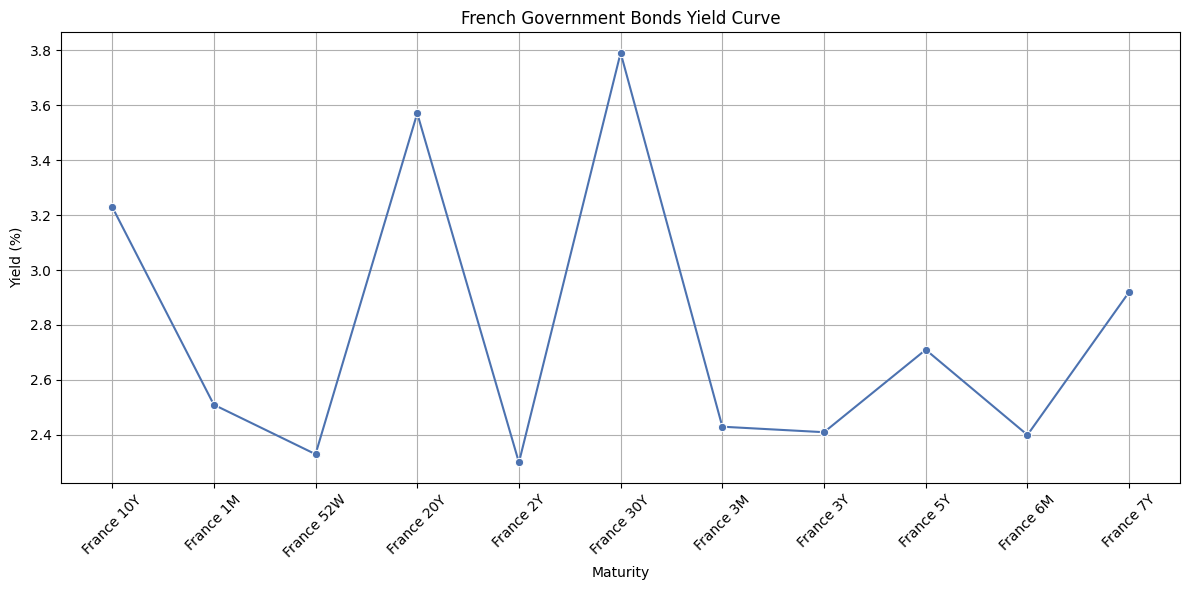

In [24]:
if bonds_df is not None:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=bonds_df, x='Maturity', y='Yield', marker='o')
    plt.title('French Government Bonds Yield Curve')
    plt.xlabel('Maturity')
    plt.ylabel('Yield (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()